## 0. Pre-processing of FFHQ Images

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import mediapipe as mp
import dlib
from matplotlib import pyplot as plt
from imutils import face_utils

In [2]:
image_dir = os.path.expanduser('./Data/ffhq512')
image_filenames = sorted(os.listdir(image_dir))

# MediaPipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)
MP_LANDMARKS = {
    'left_eye': [463, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 362], 
    'right_eye': [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7], 
    'left_iris': [474, 475, 477, 476], 
    'right_iris': [469, 470, 471, 472], 
    'nose': [193, 168, 417, 122, 351, 196, 419, 3, 248, 236, 456, 198, 420, 131, 360, 49, 279, 48, 278, 219, 439, 59, 289, 218, 438, 237, 457, 44, 19, 274],
    'mouth': [0, 267, 269, 270, 409, 306, 375, 321, 405, 314, 17, 84, 181, 91, 146, 61, 185, 40, 39, 37]
}

# dlib setup
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
DLIB_REGIONS = {
    'left_eye': list(range(36, 42)),
    'right_eye': list(range(42, 48)),
    'nose': list(range(27, 36)),
    'mouth': list(range(48, 61))
    }

I0000 00:00:1751317375.865482 20251335 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1751317375.867744 20251838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751317375.874716 20251839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1751317376.333307 20251844 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


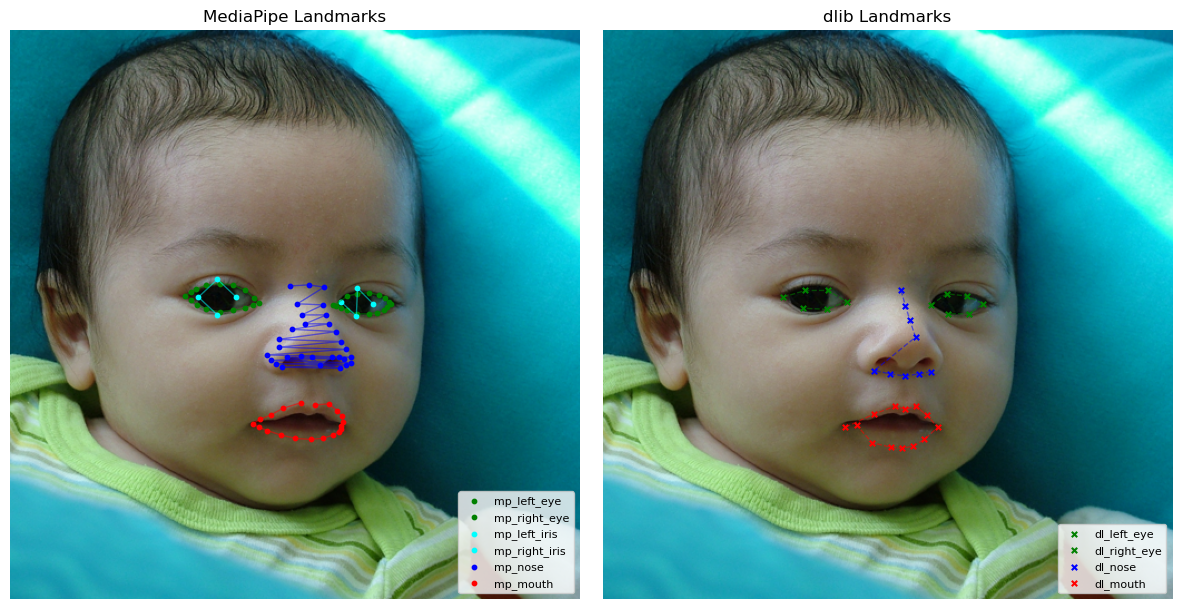

In [3]:
# Check both MP and dlib Landmarks
COLOR_MAP = {
    'left_eye': 'green', 'right_eye': 'green',
    'left_iris': 'cyan', 'right_iris': 'cyan',
    'nose': 'blue', 'mouth': 'red'
}

test_img_path = os.path.join(image_dir, image_filenames[0])
img_bgr = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
h, w = img_rgb.shape[:2]

# Run detectors
mp_output = face_mesh.process(img_rgb)
dlib_faces = detector(img_gray)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.imshow(img_rgb)
    ax.axis('off')

# MediaPipe landmarks
if mp_output.multi_face_landmarks:
    mp_landmarks = mp_output.multi_face_landmarks[0]
    for region, indices in MP_LANDMARKS.items():
        color = COLOR_MAP.get(region, 'yellow')
        for i, idx in enumerate(indices):
            lm = mp_landmarks.landmark[idx]
            x, y = int(lm.x * w), int(lm.y * h)
            axs[0].scatter(x, y, c=color, s=10, label=f'mp_{region}' if i == 0 else '')
        region_pts = np.array([[int(mp_landmarks.landmark[i].x * w), int(mp_landmarks.landmark[i].y * h)] for i in indices])
        axs[0].plot(region_pts[:, 0], region_pts[:, 1], color=color, linewidth=1, alpha=0.5)
    axs[0].set_title('MediaPipe Landmarks')

# dlib landmarks
for face in dlib_faces:
    shape = predictor(img_gray, face)
    shape_np = face_utils.shape_to_np(shape)
    for region, indices in DLIB_REGIONS.items():
        color = COLOR_MAP.get(region, 'gray')
        for i, idx in enumerate(indices):
            x, y = shape_np[idx]
            axs[1].scatter(x, y, c=color, marker='x', s=15, label=f'dl_{region}' if i == 0 else '')
        region_pts = shape_np[indices]
        axs[1].plot(region_pts[:, 0], region_pts[:, 1], color=color, linestyle='--', linewidth=1, alpha=0.5)
    axs[1].set_title('dlib Landmarks')

# Legends for both subplots
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
def clahe(image_bgr):
    '''
    Converts BGR image to grayscale and applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to
    enhance local constrast (divides image into smaller parts and adjusts contrast of each part separately)
    '''
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8, 8))
    return clahe.apply(gray)

def pixel_intensity_std(img_gray, region_mask): 
    '''
    Compute std dev of grayscale pixel intensities within region mask
    '''
    region_pixels = cv2.bitwise_and(img_gray, img_gray, mask=region_mask)
    return np.std(region_pixels[region_mask==255])

def region_occlusion_score(img_bgr, landmarks, shape):
    '''
    Flags if overall region texture variation too low (indicating occlusion)
    '''
    img_gray = clahe(img_bgr)
    h, w = img_bgr.shape[:2]
    mp_occ_inds, dl_occ_inds = [], []
    # Mediapipe occlusion check: 
    if landmarks: 
        for region, indices in MP_LANDMARKS.items(): 
            region_pts = np.array([[int(mp_landmarks.landmark[i].x * w), int(mp_landmarks.landmark[i].y * h)] for i in indices])
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillConvexPoly(mask, region_pts, 255)
            std_val = pixel_intensity_std(img_gray, mask)
            mp_occ_inds.append(std_val < 10)
    # dlib occlusion check: 
    if shape is not None:
        for region, indices in DLIB_REGIONS.items():
            region_pts = shape_np[indices]
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillConvexPoly(mask, region_pts, 255)
            std_val = pixel_intensity_std(img_gray, mask)
            dl_occ_inds.append(std_val < 10)
    mp_flag = sum(mp_occ_inds) / len(mp_occ_inds) > 0.5 if mp_occ_inds else False
    dl_flag = sum(dl_occ_inds) / len(dl_occ_inds) > 0.5 if dl_occ_inds else False
    return mp_flag or dl_flag

def side_profile(landmarks, shape):
    '''
    Flags if image is a side profile (based on nose & eyes landmarks)
    '''
    flags = []
    # Mediapipe check: 
    if landmarks: 
        nose = landmarks.landmark[1].x 
        eye_mid = (landmarks.landmark[33].x + landmarks.landmark[263].x) / 2
        flags.append(abs(nose - eye_mid) > 0.10)
    # dlib check: 
    if shape is not None: 
        nose = shape[30][0]
        eye_mid = (shape[36][0] + shape[45][0]) / 2
        flags.append(abs(nose - eye_mid) > 25)
    return any(flags)

def eye_occlusion(img_bgr, landmarks, shape): 
    '''
    Flags images with eyeocclusion using:
    - mp_flag: True if MediaPipe detects eye occlusion or closure
    - dl_flag: True if dlib detects eye occlusion
    - combined: True if either flag is True (returned)
    '''
def eye_occlusion(img_bgr, landmarks, shape):
    '''
    Flags images with eye occlusion using:
    - mp_flag: True if MediaPipe detects low texture/mean intensity in eye or iris, or closed eyes
    - dl_flag: True if dlib detects low texture or compressed eye width
    '''
    img_gray = clahe(img_bgr)
    h, w = img_bgr.shape[:2]
    mp_flags, dl_flags = [], []

    if landmarks:
        for eye in ['left_eye', 'right_eye']:
            region_pts = np.array([[int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)] for i in MP_LANDMARKS[eye]])
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillConvexPoly(mask, region_pts, 255)
            std_val = pixel_intensity_std(img_gray, mask)
            mean_val = np.mean(img_gray[mask == 255])
            mp_flags.append(std_val < 10 or mean_val < 50)

        for iris in ['left_iris', 'right_iris']:
            iris_pts = np.array([[int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)] for i in MP_LANDMARKS[iris]])
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillConvexPoly(mask, iris_pts, 255)
            iris_std = pixel_intensity_std(img_gray, mask)
            mp_flags.append(iris_std < 6)

        def mp_pt(idx): return np.array([landmarks.landmark[idx].x * w, landmarks.landmark[idx].y * h])
        p1, p2, p3, p4, p5, p6 = [mp_pt(i) for i in [33, 160, 158, 133, 153, 144]]
        ear = (np.linalg.norm(p2 - p6) + np.linalg.norm(p3 - p5)) / (2.0 * np.linalg.norm(p1 - p4))
        mp_flags.append(ear < 0.18)

    if shape is not None:
        for eye in ['left_eye', 'right_eye']:
            region_pts = np.array([shape[i] for i in DLIB_REGIONS[eye]])
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillConvexPoly(mask, region_pts, 255)
            std_val = pixel_intensity_std(img_gray, mask)
            dl_flags.append(std_val < 10)
        left_eye_dist = np.linalg.norm(shape[36] - shape[39])
        right_eye_dist = np.linalg.norm(shape[42] - shape[45])
        dl_flags.append(min(left_eye_dist, right_eye_dist) < 5)

    mp_flag = sum(mp_flags) >= 2
    dl_flag = any(dl_flags)
    return mp_flag or dl_flag


def nose_occlusion(img_bgr, landmarks, shape):
    '''
    Flags images with nose occlusion using:
    - mp_flag: True if MediaPipe detects low texture variability over the nose region
    - dl_flag: True if dlib detects low texture variability over the nose region
    - combined: True if either flag is True (returned)
    '''
    img_gray = clahe(img_bgr)
    h, w = img_bgr.shape[:2]
    mp_flag = dl_flag = False
    if landmarks:
        region_pts = np.array([[int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)] for i in MP_LANDMARKS['nose']])
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillConvexPoly(mask, region_pts, 255)
        std_val = pixel_intensity_std(img_gray, mask)
        mp_flag = std_val < 10
    if shape is not None:
        region_pts = np.array([shape[i] for i in DLIB_REGIONS['nose']])
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillConvexPoly(mask, region_pts, 255)
        std_val = pixel_intensity_std(img_gray, mask)
        dl_flag = std_val < 10
    return (mp_flag or dl_flag)

def mouth_occlusion(img_bgr, landmarks, shape):
    '''
    Flags images with mouth occlusion using:
    - mp_flag: True if MediaPipe detects low texture variability over the mouth region
    - dl_flag: True if dlib detects low texture variability over the mouth region
    - combined: True if either flag is True (returned)
    '''
    img_gray = clahe(img_bgr)
    h, w = img_bgr.shape[:2]
    mp_flag = dl_flag = False
    if landmarks:
        region_pts = np.array([[int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)] for i in MP_LANDMARKS['mouth']])
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillConvexPoly(mask, region_pts, 255)
        std_val = pixel_intensity_std(img_gray, mask)
        mp_flag = std_val < 10
    if shape is not None:
        region_pts = np.array([shape[i] for i in DLIB_REGIONS['mouth']])
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillConvexPoly(mask, region_pts, 255)
        std_val = pixel_intensity_std(img_gray, mask)
        dl_flag = std_val < 10
    return (mp_flag or dl_flag)

{'clean': 44376, 'partial_occlusion': 4594, 'side_profile': 21030}


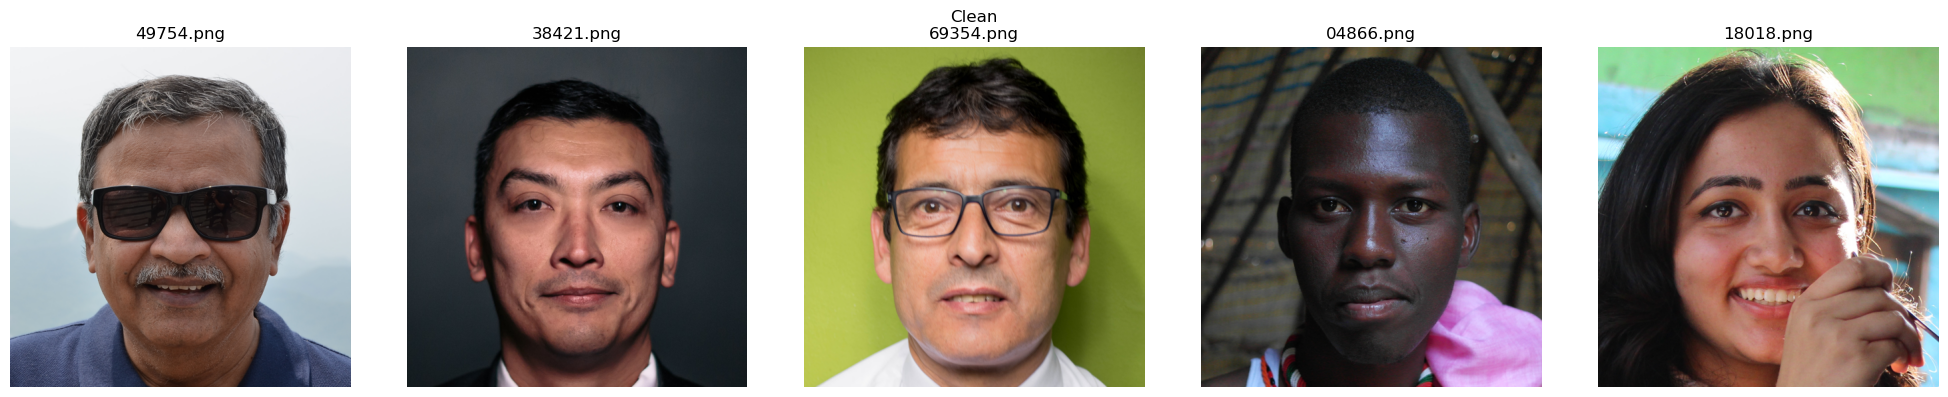

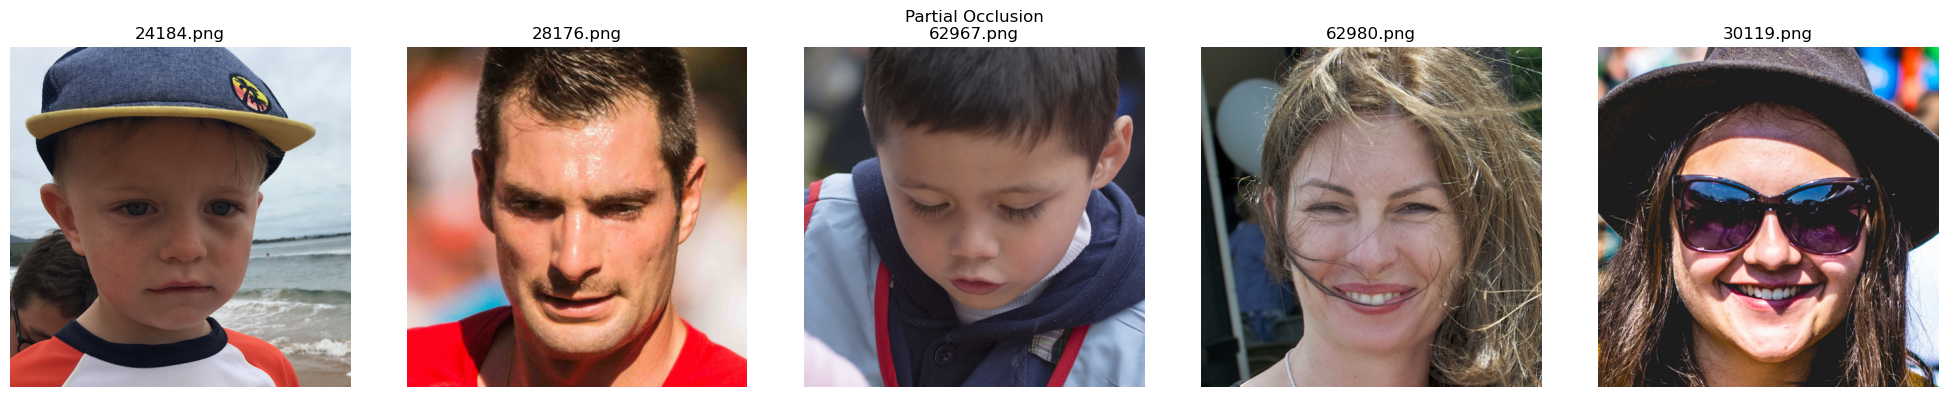

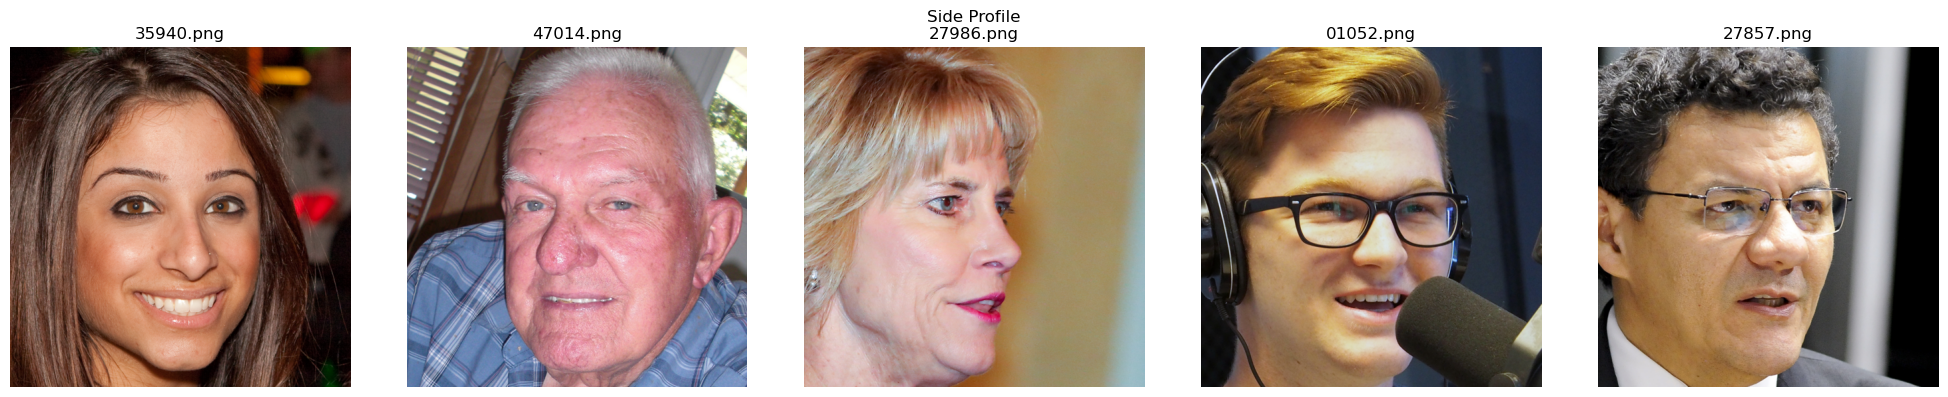

In [15]:
results = {}
for filename in image_filenames:
    img_path = os.path.join(image_dir, filename)
    img_bgr = cv2.imread(img_path)
    if img_bgr is None: continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    output = face_mesh.process(img_rgb)
    faces = detector(img_gray)
    face_landmarks = output.multi_face_landmarks[0] if output.multi_face_landmarks else None
    shape_np = face_utils.shape_to_np(predictor(img_gray, faces[0])) if len(faces) > 0 else None

    side_flag = side_profile(face_landmarks, shape_np)
    occ_flag = region_occlusion_score(img_bgr, face_landmarks, shape_np)
    eye_flag = eye_occlusion(img_bgr, face_landmarks, shape_np)
    nose_flag = nose_occlusion(img_bgr, face_landmarks, shape_np)
    mouth_flag = mouth_occlusion(img_bgr, face_landmarks, shape_np)

    if side_flag: label = 'side_profile'
    elif any([occ_flag, eye_flag, nose_flag, mouth_flag]): label = 'partial_occlusion'
    else: label = 'clean'
    results[filename] = label

results_df = pd.DataFrame(list(results.items()), columns=['filename', 'label'])
results_df.to_csv('./Data/image_occlusion_labels.csv', index=False)

summary = {k: list(results.values()).count(k) for k in ['clean', 'partial_occlusion', 'side_profile']}
print(summary)

for k in summary:
    samples = [f for f, v in results.items() if v == k]
    if not samples:
        continue
    samples = random.sample(samples, min(5, len(samples)))
    fig, axs = plt.subplots(1, len(samples), figsize=(4 * len(samples), 4))
    fig.suptitle(k.replace('_', ' ').title())
    if len(samples) == 1:
        axs = [axs]
    for ax, fname in zip(axs, samples):
        img = cv2.imread(os.path.join(image_dir, fname))
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(fname)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

---
## 1. Mask Building & Noising Strategies

In [17]:
# Region tagging
def generate_region_mask(img_shape, landmarks, region_keys):
    h, w = img_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    for region in region_keys:
        pts = np.array([
            [int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)]
            for i in MP_LANDMARKS.get(region, [])
        ])
        if pts.size:
            cv2.fillConvexPoly(mask, pts, 255)
    return mask

MASK_COMBINATIONS = {
    'left_eye': ['left_eye'],
    'right_eye': ['right_eye'],
    'eyes': ['left_eye', 'right_eye'],
    'nose': ['nose'],
    'mouth': ['mouth'],
    'sunglasses': ['left_eye', 'right_eye', 'nose'],
    'mask': ['nose', 'mouth'],
    'full_face': ['left_eye', 'right_eye', 'nose', 'mouth']
}

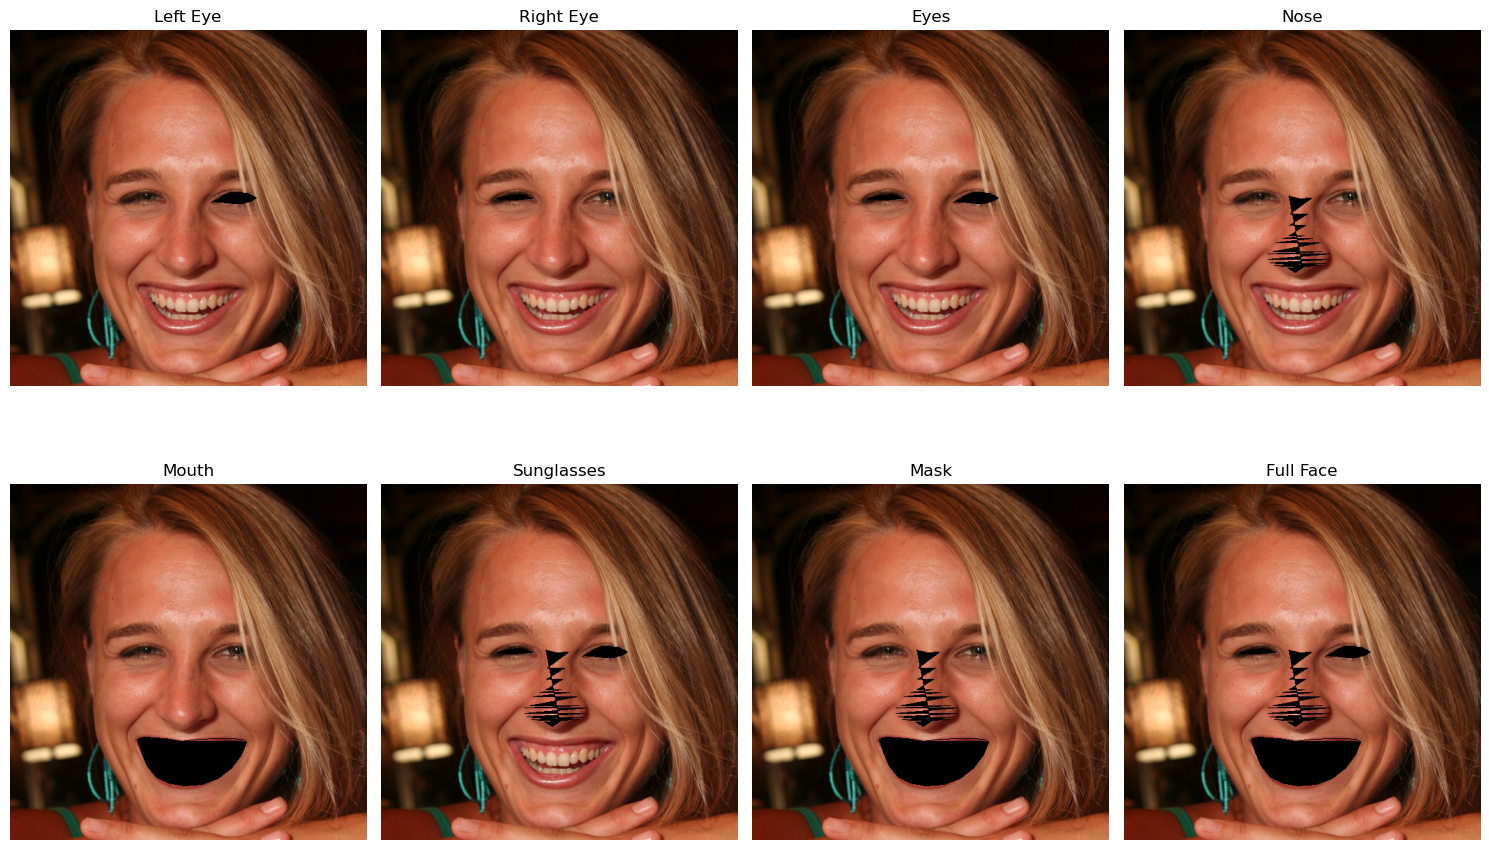

In [21]:
clean_files = [f for f, label in results.items() if label == 'clean']
img_path = os.path.join(image_dir, clean_files[0])
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w = img_rgb.shape[:2]

output = face_mesh.process(img_rgb)
landmarks = output.multi_face_landmarks[0] if output.multi_face_landmarks else None

if landmarks:
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))
    axs = axs.flatten()

    for ax, (mask_name, region_keys) in zip(axs, MASK_COMBINATIONS.items()):
        mask = generate_region_mask((h, w), landmarks, region_keys)
        masked_img = img_rgb.copy()
        masked_img[mask == 255] = 0
        ax.imshow(masked_img)
        ax.set_title(mask_name.replace('_', ' ').title())
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No face detected.")

In [ ]:
# Noising Strategies
def apply_noising(img, mask=None, strategy='mixed', noise_std=10, random_mask=False, p_rd=0.15, p_mix=0.5, dilation_iters=5):
    '''
    Allows different noising strategies: 
    - Random masking (without using structured mask based on landmark regions) 100*p_rd% of pixels - for MAE benchmark
    - Blackout masking on landmark regions from structured mask
    - Gaussian masking on landmark regions from structured mask
    - Mixed masking on landmark regions 100*p_mix% of pixels using blackout and remaining using Gaussian
    - Dilation blur masking to expand structured masks beyond the landmark boundaries
    '''
    h, w = img.shape[:2]
    if random_mask or mask is None:
        mask = (np.random.rand(h, w) < p_rd).astype(np.uint8) * 255
    result = img.copy()

    if strategy == 'blackout':
        result[mask == 255] = 0
    elif strategy == 'blur':
        blurred = cv2.GaussianBlur(img, (15, 15), 10)
        result[mask == 255] = blurred[mask == 255]
    elif strategy == 'blur+noise':
        blurred = cv2.GaussianBlur(img, (15, 15), 10).astype(np.float32)
        noise = np.random.normal(0, noise_std, img.shape).astype(np.float32)
        blurred[mask == 255] += noise[mask == 255]
        result[mask == 255] = np.clip(blurred, 0, 255)[mask == 255].astype(np.uint8)
    elif strategy == 'mixed':
        rand = np.random.rand(h, w)
        blackout_mask = ((mask == 255) & (rand < p_mix)).astype(np.uint8) * 255
        blur_mask = ((mask == 255) & (rand >= p_mix)).astype(np.uint8) * 255
        blurred = cv2.GaussianBlur(img, (15, 15), 10)
        result[blackout_mask == 255] = 0
        result[blur_mask == 255] = blurred[blur_mask == 255]
    elif strategy == 'dilated_blur':
        kernel = np.ones((5, 5), np.uint8)
        dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iters)
        blurred = cv2.GaussianBlur(img, (15, 15), 10)
        result[dilated_mask == 255] = blurred[dilated_mask == 255]
    return result

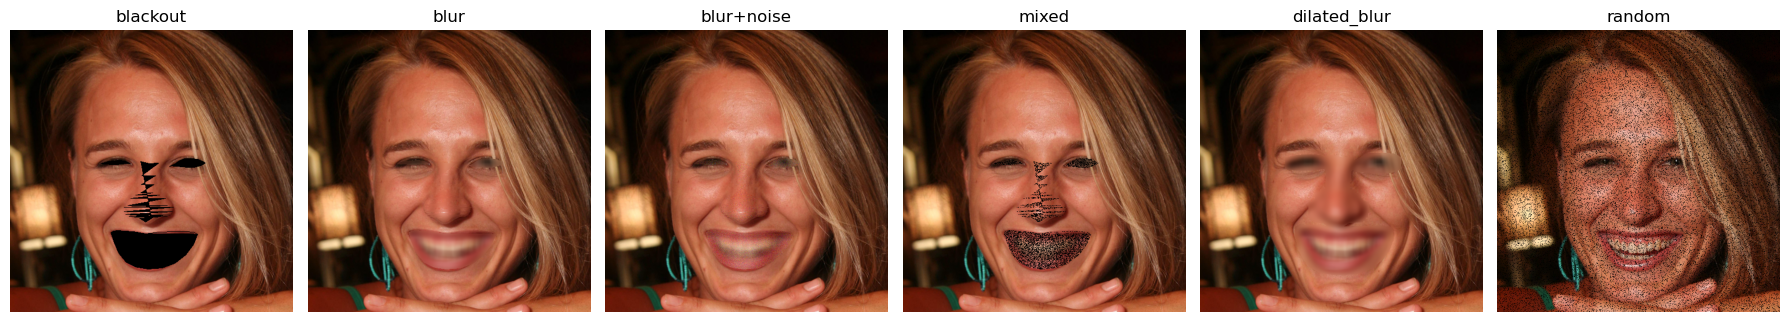

In [32]:
# Pick a sample clean image and generate region mask for 'full_face'
img_path = os.path.join(image_dir, clean_files[0])
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

output = face_mesh.process(img_rgb)
landmarks = output.multi_face_landmarks[0] if output.multi_face_landmarks else None

if landmarks:
    mask = generate_region_mask(img_rgb.shape, landmarks, MASK_COMBINATIONS['full_face'])
    strategies = ['blackout', 'blur', 'blur+noise', 'mixed', 'dilated_blur', 'random']
    fig, axs = plt.subplots(1, len(strategies), figsize=(18, 4))
    for ax, strat in zip(axs, strategies):
        if strat == 'random':
            result = apply_noising(img_rgb, mask=None, strategy='blackout', random_mask=True)
        else:
            result = apply_noising(img_rgb, mask=mask, strategy=strat)
        ax.imshow(result)
        ax.set_title(strat)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No face detected.')


# 2. Load Data

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CleanFFHQDataset(Dataset):
    def __init__(self, image_dir, filenames, transform=None):
        self.image_dir = image_dir
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.filenames[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

def get_clean_ffhq_dataloaders(image_dir, clean_filenames, train_ratio=0.8, batch_size=64, seed=123):
    '''
    Splits clean FFHQ images into train/test and returns dataloaders (no masking applied).
    '''
    rng = random.Random(seed)
    random.shuffle(clean_filenames)
    split_idx = int(len(clean_filenames) * train_ratio)
    train_files, test_files = clean_filenames[:split_idx], clean_filenames[split_idx:]

    transform = transforms.Compose([transforms.ToTensor(),])

    train_dataset = CleanFFHQDataset(image_dir, train_files, transform)
    test_dataset = CleanFFHQDataset(image_dir, test_files, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader
